# Modelling the Tufa layer in the Ammer Valley Quaternary floodplain stratigraphy

This notebook explain step-by-step how to create a object based sedimentary structure model using HyVR and the python environment. The model will represent the tufa layer in the Quaternary floodplain sediments of the Ammer Valler, Tuebingen, Germany.

## Packages

Besides HyVR, we use numpy for numerical computing. Since we are interested in using this model for posterior flow simulations, we will use the capabilities in flopy, specially for handling the grid and exporting VTKs (3D render models).

In [1]:
from hyvr.tools import ferguson_curve  # used for the channel curve creation
from hyvr import channel  # channel object creation
from hyvr import trough  # trough creation
import scipy  # general scientific calculations
import flopy  # our modelling interface
import numba
import numpy as np  # general numerical functions and array manipulation
import matplotlib.pyplot as plt  # plotting functions

## Grid/Model creation

HyVR should work on any structured grid. One example would be creating a grid with `np.meshgrid`, the numpy function for grids. However, we are interested in flow simulations, and MODFLOW is the standard. The python interface, flopy has grid creation capabilities that can be easily translated to MODFLOW grids, thus we use that for our grid creation

In [2]:
# Model creation:
name = "ammer_V0602"
ws = "."
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    exe_name="mf6",
    version="mf6",
    sim_ws=ws,
)
# Nam file
model_nam_file = "{}.nam".format(name)
# Groundwater flow object:
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=name,
    model_nam_file=model_nam_file,
    save_flows=True,
)
# Grid properties:
Lx = 900  # problem lenght [m]
Ly = 600  # problem width [m]
H = 7  # aquifer height [m]
delx = 1.5  # block size x direction
dely = 1.5  # block size y direction
delz = 0.2  # block size z direction
nlay = int(H / delz)
ncol = int(Lx / delx)  # number of columns
nrow = int(Ly / dely)  # number of layers

# Flopy Discretizetion Objects (DIS)
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    xorigin=0.0,
    yorigin=0.0,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=dely,
    delc=delx,
    top=7.0,
    botm=np.arange(H - delz, 0 - delz, -delz),
)

# Node property flow
k = 1e-5  # Model conductivity in m/s
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=0,  # This we define the model as confined
    k=k,
)

# Acessing the grid
grid = gwf.modelgrid

# cell centers
centers = grid.xyzcellcenters

X = centers[0]
Y = centers[1]
Z = centers[2]

# broadcasting the X, Y to the same shape as Z (full grid shape)
X = np.broadcast_to(X, Z.shape)
Y = np.broadcast_to(Y, Z.shape)

## Modelling Sedimentary Structures

We base the framework on the original work from Bennett et al (2018), which has written the first version of HyVR. The framework is hierarchical, meaning that structures can be organized in different scales depending on the context, but that they may represent complex sedimentary archictectures.

From the analysis of Holdt et al. (2024), two distinct environments existed in the Ammer Valley floodplain during the tufa layer deposition. In the lower part ($\approx 5 m$ thick) a paludal environment predominated with the following facies and associated architecture assemblage:

1. A open marsh environemnt (T4), mixed with parts of wetlands (T7) and meadows (T6). The marsh environment is characterized by the presence of tufa clasts and organic matter, with a high proportion of tufa clasts. The wetland environment is characterized by the presence of tufa clasts and organic matter, with a high proportion of organic matter. The meadow environment is characterized by the presence of tufa clasts and organic matter, with a high proportion of organic matter. In terms of architecture, the marsh environemt is characterized as a anastamosed stable channel sytem of irregular sinuosity where the T4 facies is present. In the proximal area, wetland predominates with a seasonal variation of wet and dry morphology. This area is characterized by the T7 facies. In the distal area, meadows predominate, with predominant dry morphology. This area is characterized by the T6 facies.

2. Closed ponds (T2). The closed pond environment is characterized by a  higher proportion of tufa clasts and silt, with a high proportion of tufa clasts. The architecture is characterized by a closed pond with a high proportion of tufa clasts. The architecture representation of such environemts is 

3. Peat (T8). The peat is formed when the open marsh or pond environments where the depth reaches a certain height, and the plants can no longer survive and produce calcium carbonate. They form lenses on top of T2 or T4.

Here is a picture of the architectural assembly of the lower part of the tufa layer:

![Tufa layer architecture](imgs/3d_block_lower_holocene.png)

On the upper part, Holdt et al. (2024) identified a shift in the environment. The system has become more energetic, forming a channelized depositing system. On the channel, the higher granulometry gravel deposits (G1), while in the proximal area, clastic tufa (T1) has been deposited. In distal areas the clay (C1) is predominant. Eventually, with the reduction of the sedimentary load, the system became a pure clay deposit (C1), which we see confining the tufa layer.

Here is a picture of the architectural assembly of the upper part of the tufa layer:


![Tufa layer architecture](imgs/upper_holocene.png)

## Aggradation



The aggradation in the lower part, we will think about surfaces. At each sequence. the upper surface will be defined based on the underlying environment. The surface will be lower in the open marsh and pond areas and higher in the meadow areas, although the difference is rather small. We will model these different heights with the use of gaussian process and gaussian process regression. Peat will form randomly at each simulation in the thicker areas of pond or open marsh.
The upper part will be modelled as a single sequence.


The algorithm is organized as such:

1. Define the sequence thicknesses (sampled from a distribution)
2. Over the thickness t:
    2.1. Iterate over each facies f associated with the aggradation period:
        2.1.1. generate lens of thickness t at a randomly sampled location and with reasonably chosen dimensions. Assign it to facies f
        2.1.2. repeat 2.1 until the proportion of facies f is slightly above the calculated proportion (since one object can erode the previous we use slightly bigger proportion in the algorithm).
    2.3. Generate lens of thickness t or max_peat_thickness at a randomly sampled location and with reasonably chosen dimension of the facies peat
    2.4. repeat 2.3 until proportion of peat is the same as the calculated proportion.
    2.5. Generate a channel starting on the left of the grid and on a randomly sampled high y value with thickness t or max_channel_thickness and width $\approx$ 4 m.
    2.6. Generate a channel startubg on the left of the grid (x=0) and on a randomly sampled low y values with thickness t or max_channel_thickness and width $\approx$ 4 m.
3. Add the base level by thickness t and repeat 2. unil the end of the sequence (7m high).


### Defining the sequence of thicknesses

We will assume an average thickness of 0.7 m. The first layer in the system is modelled deterministically. It is $\approx$ 0.4 m thickness and composed with light color tufa with fossil and low organic matter content. The remaining layers are modelled probabilistically.
 which means that in the sequence of 7 m, we randomly sample 10 thicknesses:

Below we have calculated a distribution function that randomly sampled thicknesses with the characteristics above:

In [3]:
# according to answer in : https://math.stackexchange.com/questions/291174/probability-distribution-of-the-subinterval-lengths-from-a-random-interval-divis
# The cumulative distribution function for intervals randomly sampled from the interval [0,a] is:
simulated_thickness = 7 - 0.5
n = 9
print(f"With the number of layers: {n}")
F = lambda t: 1 - ((simulated_thickness - t) / simulated_thickness) ** (n - 1)
# The probability density function is then:
f = (
    lambda t: (n - 1)
    / simulated_thickness
    * ((simulated_thickness - t) / simulated_thickness) ** (n - 2)
)
mean_thickness = scipy.integrate.quad(lambda t: t * f(t), 0, simulated_thickness)[0]
median_thickness = scipy.optimize.fsolve(lambda t: F(t) - 0.5, mean_thickness)[0]
# The median thickness would be:
print(f"The median thickness is:{median_thickness}")
# The mean thickness would be:
print(f"The mean thickness is:{mean_thickness}")

With the number of layers: 9
The median thickness is:0.539473719169637
The mean thickness is:0.7222222222222221


The code above has calculated that a 9 layer model would on average produce a thickness agreeable with measured average of 0.7 meters.
To generate the model thicknesses we can just generate random samples on the interval from 0 to the total modelled thickness. Unfortunately, due to cell size restrictions, we cannot model layers that are too small (< 0.3 m), therefore we iterate unil we have a thickness model with layers that are bigger than 0.3:

In [4]:
min_thick = 0
while min_thick < 0.3:
    zs = np.random.uniform(0, simulated_thickness, size=n - 1)
    ordered_zs = np.sort(zs)
    ordered_zs = np.append(ordered_zs, simulated_thickness)
    ordered_zs = np.append(0, ordered_zs)
    thicknesses = np.diff(ordered_zs)
    min_thick = np.min(thicknesses)

In [5]:
print(f"The thickness array is:{thicknesses})")
print(f"The minimum thickness is:{min_thick}")
print(f"The total thickness is:{np.sum(thicknesses)}")
print(f"The mean thickness is:{np.mean(thicknesses)}")
print(f"THe number of layers is:{len(thicknesses)}")

The thickness array is:[0.42203629 0.80495885 0.37050806 1.11466697 1.99454155 0.70181041
 0.35003365 0.41328443 0.32815979])
The minimum thickness is:0.3281597883612406
The total thickness is:6.5
The mean thickness is:0.7222222222222222
THe number of layers is:9


In [6]:
testf = np.empty((nrow, ncol), dtype=np.int32)
np.unique(testf)

array([-871104272, -871104176, -870179472, -864631504, -864631184,
       -859450576, -859294992, -819301776, -815589520, -815589392,
       -815318480, -802517584, -799645040, -785786384, -762038784,
       -761995808, -730857376, -723722368, -721911776, -720179648,
       -720178864, -720126240, -720126224, -720126216, -720126200,
       -720126192, -720126144, -720126096, -720126064, -720126048,
       -720126032, -720126024, -720126008, -720125992, -720125984,
       -720125952, -720125944, -720125896, -720125848, -720125832,
       -720125824, -720125776, -720125728, -720125696, -720125648,
       -720125584, -720125576, -720125560, -720125504, -720125472,
       -720125440, -720125408, -720125376, -720125344, -720125312,
       -720125280, -720125184, -720125152, -720125120, -720125088,
       -720125056, -720125032, -720124944, -720124912, -720124880,
       -720124848, -720124816, -720124784, -720124752, -720124720,
       -720124624, -720124592, -720124560, -720124528, -720124

In [10]:
# creating anastamosing channel pattern:
main_channels = []
channels = []
for i in range(6):
    ystart = np.random.uniform(0, 600)
    channel_curve = ferguson_curve(
        h=0.3,
        k=np.pi / 200,
        eps_factor=(np.pi / 1.5) ** 2,
        flow_angle=0.0,
        s_max=1500,
        xstart=-500,
        ystart=ystart,
    )
    main_channels.append(channel_curve)
    indexes = np.random.choice(
        np.arange(channel_curve[0].shape[0]), size=4, replace=False
    )
    xstart = channel_curve[0][indexes]
    ystart = channel_curve[1][indexes]
    for x, y in zip(xstart, ystart):
        channel_derived_channel = ferguson_curve(
            h=0.3,
            k=np.pi / 200,
            eps_factor=(np.pi / 1.5) ** 2,
            flow_angle=np.random.uniform(-np.pi / 18, np.pi / 18),
            s_max=1000,
            xstart=x,
            ystart=y,
        )
        channels.append(channel_derived_channel)

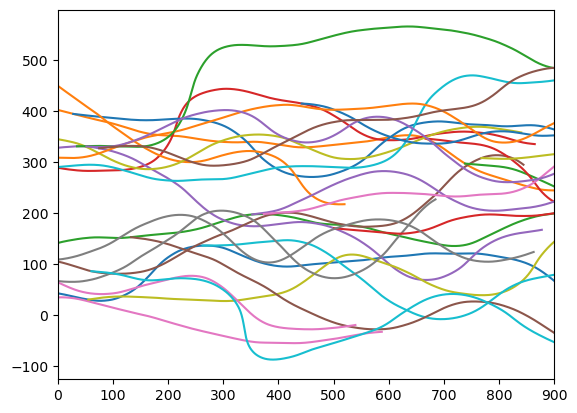

In [11]:
fig, ax = plt.subplots()
for channel_ in main_channels:
    ax.plot(channel_[0], channel_[1])
for channel_ in channels:
    ax.plot(channel_[0], channel_[1])
ax.set_xlim(0, 900)
plt.show()

In [7]:
# min distance function for assigning the T6 facies:


@numba.jit(nopython=True, parallel=True)
def min_distance(x, y, P):
    """
    Compute minimum/a distance/s between
    a point P[x0,y0] and a curve (x,y)

    ARGS:
        x, y      (array of values in the curve)
        P         (array of points to sample)

    Returns min indexes and distances array.
    """
    distance = lambda X, x, y: np.sqrt((X[0] - x) ** 2 + (X[1] - y) ** 2)
    # compute distance
    d_array = np.zeros((P.shape[0]))
    glob_min_idx = np.zeros((P.shape[0]))
    for i in numba.prange(P.shape[0]):
        d_line = distance(P[i], x, y)
        d_array[i] = np.min(d_line)
        glob_min_idx[i] = np.argmin(d_line)
    return d_array, glob_min_idx

In [13]:
x = X[0, :, :].ravel()
y = Y[0, :, :].ravel()
P = np.column_stack([x, y])
total_channels = main_channels + channels
min_distance_array = np.zeros((P.shape[0], len(total_channels)))
for i, channel_ in enumerate(total_channels):
    min_distance_array[:, i], _ = min_distance(channel_[0], channel_[1], P)

<BarContainer object of 30 artists>

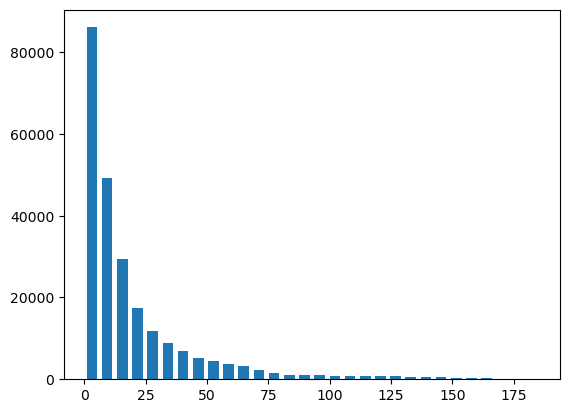

In [14]:
min_arr = min_distance_array.min(axis=1)

hist, bins = np.histogram(min_arr, bins=30)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align="center", width=width)

In [18]:
# cut the proportion to 30 % of the cells in the x, y plane
# Assuming `min_array` and `t` are already defined

# Get the sorted indices of t
sorted_indices = np.argsort(min_arr)

# Calculate the number of indices to select (30% of the total)
num_indices = int(len(sorted_indices) * 0.15)

# Select the last 30% of the indices
selected_indices = sorted_indices[-num_indices:]

# Print the selected indices
print(selected_indices)

[163834  16387 232547 ...     72     74     73]


In [19]:
primitive = np.ones_like(min_arr, dtype=np.int32) * 7
primitive = np.ravel(primitive)
primitive[selected_indices] = 6
primitive = primitive.reshape((Z.shape[1], Z.shape[2]))

facies = np.zeros_like(Z, dtype=np.int32)
facies[Z <= thicknesses[0]] = 7

for i in range(Z.shape[0]):
    z_ = Z[i, :, :]
    if np.all(z_ < thicknesses[0]):
        facies[i, :, :] = primitive

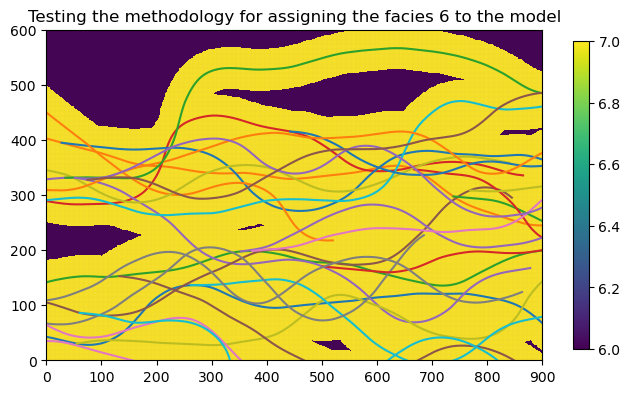

In [20]:
# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Next we create an instance of the PlotMapView class
mapview = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=34)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = mapview.plot_grid(alpha=0.01)
quadmesh = mapview.plot_array(facies)
for channel_ in main_channels:
    ax.plot(channel_[0], channel_[1])
for channel_ in channels:
    ax.plot(channel_[0], channel_[1])
t = ax.set_title("Testing the methodology for assigning the facies 6 to the model")
cb = plt.colorbar(quadmesh, shrink=0.5)

In [21]:
## Adding ponds:
z_0 = 0
p_ponds = 0
thick = thicknesses[0]
while p_ponds < 0.30:
    x_c = np.random.uniform(0, 900)
    y_c = np.random.uniform(0, 600)
    z_c = z_0 + thick + np.random.uniform(-0.2, 0)
    a = np.random.uniform(50, 80)
    b = np.random.uniform(30, 60)
    c = thick
    azim = np.random.uniform(70, 110)
    facies_trough, dip_dir_trough, dip_trough = trough(
        X,
        Y,
        Z,
        center_coords=np.array([x_c, y_c, z_c]),
        dims=np.array([a, b, c]),
        azim=azim,
        facies=np.array([2]),
    )
    facies[facies_trough == 2] = 2
    # k[facies_trough != -1] = np.random.lognormal(mu_tufa, sigma=sigma_tufa)
    logic_tufa = (Z >= z_0) & (Z <= z_0 + thick)
    p_ponds = np.sum(facies[logic_tufa] == 2) / np.sum(logic_tufa)


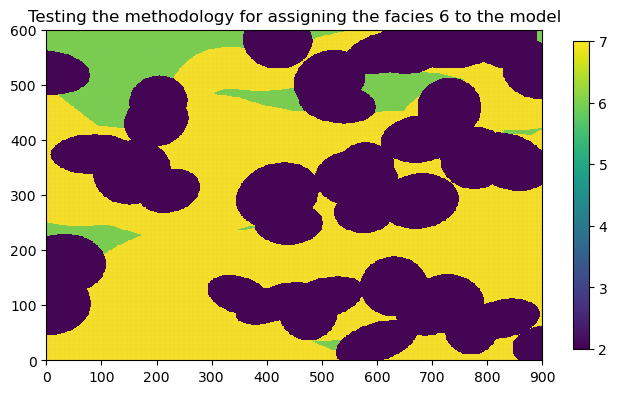

In [22]:
# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Next we create an instance of the PlotMapView class
mapview = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=32)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = mapview.plot_grid(alpha=0.01)
quadmesh = mapview.plot_array(facies)
t = ax.set_title("Testing the methodology for assigning the facies 6 to the model")
cb = plt.colorbar(quadmesh, shrink=0.5)

In [23]:
## Adding the channels, the ponds and the peat lenses
depth = thicknesses[0]
z_0 = 0
for channel_ in main_channels:
    facies_, dip_, dipdir_ = channel(
        X,
        Y,
        Z,
        z_top=z_0 + thicknesses[0],
        curve=np.c_[channel_[0], channel_[1]],
        parabola_pars=np.array([30, depth]),
        facies=np.array([4]),
    )
    facies[facies_ == 4] = 4
for channel_ in channels:
    facies_, dip_, dipdir_ = channel(
        X,
        Y,
        Z,
        z_top=z_0 + thicknesses[0],
        curve=np.c_[channel_[0], channel_[1]],
        parabola_pars=np.array([20, depth]),
        facies=np.array([4]),
    )
    facies[facies_ == 4] = 4

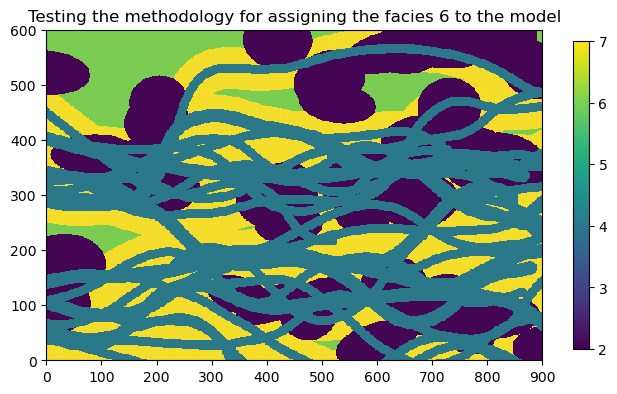

In [24]:
# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Next we create an instance of the PlotMapView class
mapview = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=32)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = mapview.plot_grid(alpha=0.01)
quadmesh = mapview.plot_array(facies)
t = ax.set_title("Testing the methodology for assigning the facies 6 to the model")
cb = plt.colorbar(quadmesh, shrink=0.5)

In [25]:
water_bodies = (facies == 2) | (facies == 4)
z_ = Z[:, 0, 0]
ind = np.where(z_ <= thicknesses[0])
layer = np.min(ind[0])
layer
water_bodies = water_bodies[layer, :, :]
xs = X[layer, :, :][water_bodies]
ys = Y[layer, :, :][water_bodies]
xs.shape
ys.shape
index_ = np.random.choice(np.arange(0, xs.shape[0]))
index_

85432

In [26]:
## adding peat lenses:
p_peat = 0
thick = thicknesses[0]
while p_peat < 0.20:
    index_ = np.random.choice(np.arange(0, xs.shape[0]))
    x_c = xs[index_]
    y_c = ys[index_]
    z_c = z_0 + thick
    a = np.random.uniform(30, 60)
    b = np.random.uniform(20, 40)
    c = thick
    azim = np.random.uniform(70, 110)
    facies_trough, dip_dir_trough, dip_trough = trough(
        X,
        Y,
        Z,
        center_coords=np.array([x_c, y_c, z_c]),
        dims=np.array([a, b, c]),
        azim=azim,
        facies=np.array([8]),
    )
    facies[facies_trough == 8] = 8
    # k[facies_trough != -1] = np.random.lognormal(mu_tufa, sigma=sigma_tufa)
    logic_tufa = (Z >= z_0) & (Z <= z_0 + thick)
    p_peat = np.sum(facies[logic_tufa] == 8) / np.sum(logic_tufa)

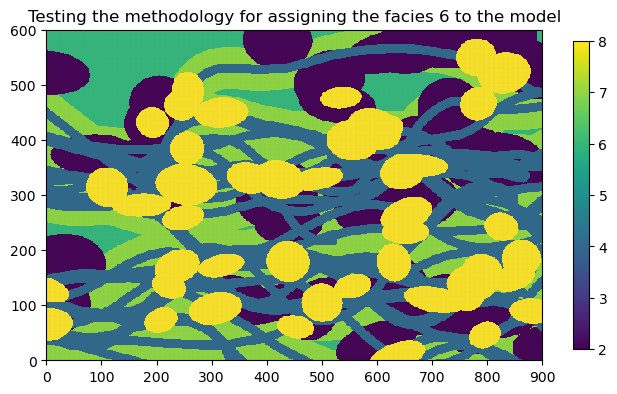

In [27]:
# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Next we create an instance of the PlotMapView class
mapview = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=32)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = mapview.plot_grid(alpha=0.01)
quadmesh = mapview.plot_array(facies)
t = ax.set_title("Testing the methodology for assigning the facies 6 to the model")
cb = plt.colorbar(quadmesh, shrink=0.5)

### Creating the upper holocene architecture

In [28]:
# defining clay facies for the background:
min_height = np.cumsum(thicknesses)[-1]
facies[Z >= min_height] = 10
# adding initial channel
x_c = -np.random.uniform(400, 600)
y_c = np.random.uniform(200, 600)
gravel_channel = ferguson_curve(
    h=0.1,
    k=np.pi / 200,
    eps_factor=(np.pi / 1.5) ** 2,
    flow_angle=0.0,
    s_max=1000 - x_c,
    xstart=x_c,
    ystart=y_c,
)

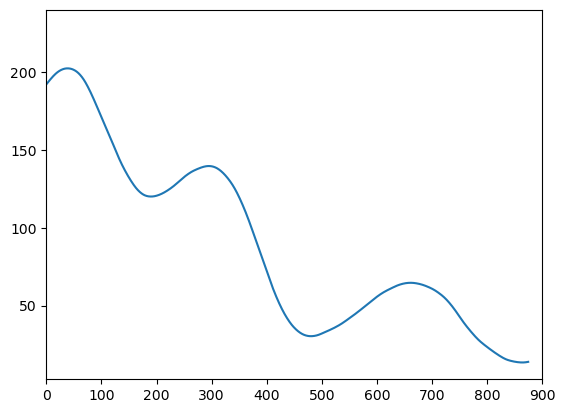

In [29]:
fig, ax = plt.subplots()
ax.plot(gravel_channel[0], gravel_channel[1])
ax.set_xlim(0, 900)
plt.show()

In [30]:
# calculating distance to the channel:
x = X[0, :, :].ravel()
y = Y[0, :, :].ravel()
P = np.column_stack([x, y])
min_distance_arr, _ = min_distance(gravel_channel[0], gravel_channel[1], P)

<BarContainer object of 30 artists>

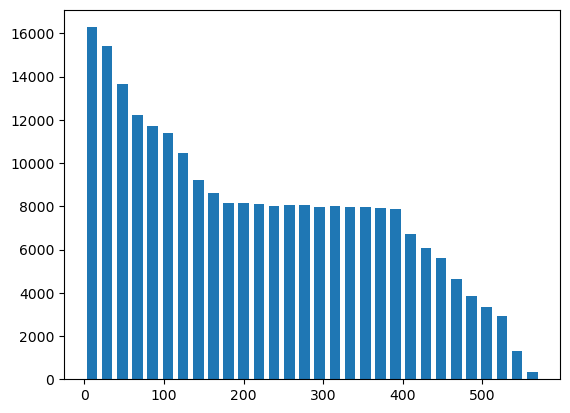

In [31]:
hist, bins = np.histogram(min_distance_arr, bins=30)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align="center", width=width)

In [32]:
indexes = np.where(min_distance_arr < 150)
indexes = indexes[0]
xs = X[0, :, :].ravel()[indexes]
ys = Y[0, :, :].ravel()[indexes]
xs.shape
ys.shape
p_tufa = 0
thick = 0.2
while p_tufa < 0.90:
    index_ = np.random.choice(np.arange(0, xs.shape[0]))
    x_c = xs[index_]
    y_c = ys[index_]
    z_c = min_height + thick
    a = np.random.uniform(30, 60)
    b = np.random.uniform(20, 40)
    c = np.random.uniform(0.2, thick + 0.2)
    azim = np.random.uniform(70, 110)
    facies_trough, dip_dir_trough, dip_trough = trough(
        X,
        Y,
        Z,
        center_coords=np.array([x_c, y_c, z_c]),
        dims=np.array([a, b, c]),
        azim=azim,
        facies=np.array([11]),
    )
    facies[facies_trough == 11] = 11
    # k[facies_trough != -1] = np.random.lognormal(mu_tufa, sigma=sigma_tufa)
    logic_tufa = (Z >= min_height) & (Z <= min_height + thick)
    # calculating distance to the channel:
    x = X[logic_tufa].ravel()
    y = Y[logic_tufa].ravel()
    P = np.column_stack([x, y])
    min_distance_arr, _ = min_distance(gravel_channel[0], gravel_channel[1], P)
    indexes = np.where(min_distance_arr < 100)
    indexes = indexes[0]
    p_tufa = np.sum(facies[logic_tufa].ravel()[indexes] == 11) / np.sum(
        logic_tufa[logic_tufa].ravel()[indexes]
    )

SystemError: CPUDispatcher(<function min_distance at 0x000001DA8CD82C20>) returned a result with an exception set

In [ ]:
## Add channel facies:
facies_, dip_, dipdir_ = channel(
    X,
    Y,
    Z,
    z_top=min_height + 0.1,
    curve=np.c_[gravel_channel[0], gravel_channel[1]],
    parabola_pars=np.array([25, thick + 0.2]),
    facies=np.array([12]),
)
facies[facies_ == 12] = 12

: 

In [ ]:
layer_height = Z[:, 0, 0]
layer_height

: 

In [ ]:
# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Next we create an instance of the PlotMapView class
mapview = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=1)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = mapview.plot_grid(alpha=0.01)
quadmesh = mapview.plot_array(facies)
t = ax.set_title("Testing the methodology for assigning the facies 6 to the model")
cb = plt.colorbar(quadmesh, shrink=0.5)

: 

The upper sequence is more critical. I am going to try to make it first. I will migrate 10 cm uppwards and continue.

In [ ]:
heights = np.arange(min_height, 7.1, 0.1)
x_c = -np.random.uniform(400, 600)
y_c = np.random.uniform(200, 600)
x = X[0, :, :].ravel()
y = Y[0, :, :].ravel()
P = np.column_stack([x, y])

heights
for height in heights[:2]:
    # adding initial channel

    gravel_channel = ferguson_curve(
        h=0.1,
        k=np.pi / 200,
        eps_factor=(np.pi / 1.5) ** 2,
        flow_angle=0.0,
        s_max=1000 - x_c,
        xstart=x_c,
        ystart=y_c,
    )
    min_distance_arr, _ = min_distance(gravel_channel[0], gravel_channel[1], P)
    indexes = np.where(min_distance_arr < 100)
    indexes = indexes[0]
    xs = x[indexes]
    ys = y[indexes]

    p_tufa = 0
    thick = 0.2
    while p_tufa < 0.90:
        index_ = np.random.choice(np.arange(0, xs.shape[0]))
        x_c = xs[index_]
        y_c = ys[index_]
        z_c = height + thick
        a = np.random.uniform(30, 60)
        b = np.random.uniform(20, 40)
        c = np.random.uniform(0.1, thick + 0.1)
        azim = np.random.uniform(70, 110)
        facies_trough, dip_dir_trough, dip_trough = trough(
            X,
            Y,
            Z,
            center_coords=np.array([x_c, y_c, z_c]),
            dims=np.array([a, b, c]),
            azim=azim,
            facies=np.array([11]),
        )
        facies[facies_trough == 11] = 11
        # k[facies_trough != -1] = np.random.lognormal(mu_tufa, sigma=sigma_tufa)
        logic_tufa = (Z >= height) & (Z <= height + thick)
        # calculating distance to the channel:
        x = X[logic_tufa].ravel()
        y = Y[logic_tufa].ravel()
        P = np.column_stack([x, y])
        min_distance_arr, _ = min_distance(gravel_channel[0], gravel_channel[1], P)
        indexes = np.where(min_distance_arr < 100)
        indexes = indexes[0]
        p_tufa = np.sum(facies[logic_tufa].ravel()[indexes] == 11) / np.sum(
            logic_tufa[logic_tufa].ravel()[indexes]
        )
    ## Add channel facies:
    facies_, dip_, dipdir_ = channel(
        X,
        Y,
        Z,
        z_top=height + 0.1,
        curve=np.c_[gravel_channel[0], gravel_channel[1]],
        parabola_pars=np.array([25, thick + 0.2]),
        facies=np.array([12]),
    )
    facies[facies_ == 12] = 12

NameError: name 'np' is not defined

In [ ]:
# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Next we create an instance of the PlotMapView class
mapview = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=1)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = mapview.plot_grid(alpha=0.01)
quadmesh = mapview.plot_array(facies)
t = ax.set_title("Testing the methodology for assigning the facies 6 to the model")
cb = plt.colorbar(quadmesh, shrink=0.5)

: 

### Creating and running the sedimentary structure algorithm

In [13]:
facies = np.zeros_like(Z, dtype=np.int32) + 7
thicknesses

array([0.42203629, 0.80495885, 0.37050806, 1.11466697, 1.99454155,
       0.70181041, 0.35003365, 0.41328443, 0.32815979])

In [14]:
x = X[0, :, :].ravel()
y = Y[0, :, :].ravel()
P = np.column_stack([x, y])
z_0 = 0.0
for thick in thicknesses:
    # creating anastamosing channel pattern:
    main_channels = []
    channels = []
    for i in range(6):
        ystart = np.random.uniform(0, 600)
        channel_curve = ferguson_curve(
            h=0.3,
            k=np.pi / 200,
            eps_factor=(np.pi / 1.5) ** 2,
            flow_angle=0.0,
            s_max=1500,
            xstart=-500,
            ystart=ystart,
        )
        main_channels.append(channel_curve)
        indexes = np.random.choice(
            np.arange(channel_curve[0].shape[0]), size=4, replace=False
        )
        xstart = channel_curve[0][indexes]
        ystart = channel_curve[1][indexes]
        for x, y in zip(xstart, ystart):
            channel_derived_channel = ferguson_curve(
                h=0.3,
                k=np.pi / 200,
                eps_factor=(np.pi / 1.5) ** 2,
                flow_angle=np.random.uniform(-np.pi / 18, np.pi / 18),
                s_max=1000,
                xstart=x,
                ystart=y,
            )
            channels.append(channel_derived_channel)
    total_channels = main_channels + channels
    min_distance_array = np.zeros((P.shape[0], len(total_channels)))
    for i, channel_ in enumerate(total_channels):
        min_distance_array[:, i], _ = min_distance(channel_[0], channel_[1], P)
    # cut the proportion to 30 % of the cells in the x, y plane
    min_arr = min_distance_array.min(axis=1)
    # Assuming `min_array` and `t` are already defined
    # Get the sorted indices of t
    sorted_indices = np.argsort(min_arr)
    # Calculate the number of indices to select (30% of the total)
    num_indices = int(len(sorted_indices) * 0.2)
    # Select the last 30% of the indices
    selected_indices = sorted_indices[-num_indices:]

    primitive = np.ones_like(min_arr, dtype=np.int32) * 7
    primitive = np.ravel(primitive)
    primitive[selected_indices] = 6
    primitive = primitive.reshape((Z.shape[1], Z.shape[2]))
    z_ = Z[:, 0, 0]
    for i in range(z_.shape[0]):
        if z_[i] >= z_0:
            facies[i, :, :] = primitive

    ## Adding ponds:
    p_ponds = 0
    while p_ponds < 0.30:
        x_c = np.random.uniform(0, 900)
        y_c = np.random.uniform(0, 600)
        z_c = z_0 + thick + np.random.uniform(0, 0.1)
        a = np.random.uniform(50, 80)
        b = np.random.uniform(30, 60)
        c = thick
        azim = np.random.uniform(70, 110)
        facies_trough, dip_dir_trough, dip_trough = trough(
            X,
            Y,
            Z,
            center_coords=np.array([x_c, y_c, z_c]),
            dims=np.array([a, b, c]),
            azim=azim,
            facies=np.array([2]),
        )
        facies[facies_trough == 2] = 2
        # k[facies_trough != -1] = np.random.lognormal(mu_tufa, sigma=sigma_tufa)
        logic_tufa = (Z >= z_0) & (Z <= z_0 + thick)
        p_ponds = np.sum(facies[logic_tufa] == 2) / np.sum(logic_tufa)

    ## Adding the channels, the ponds and the peat lenses
    for channel_ in main_channels:
        facies_, dip_, dipdir_ = channel(
            X,
            Y,
            Z,
            z_top=z_0 + thick,
            curve=np.c_[channel_[0], channel_[1]],
            parabola_pars=np.array([30, thick]),
            facies=np.array([4]),
        )
        facies[facies_ == 4] = 4
    for channel_ in channels:
        facies_, dip_, dipdir_ = channel(
            X,
            Y,
            Z,
            z_top=z_0 + thick,
            curve=np.c_[channel_[0], channel_[1]],
            parabola_pars=np.array([20, thick]),
            facies=np.array([4]),
        )
        facies[facies_ == 4] = 4
    ## assiging peat to areas close to water bodies:
    water_bodies = (facies == 2) | (facies == 4)
    z_ = Z[:, 0, 0]
    ind = np.where(z_ <= z_0 + thick)
    layer = np.min(ind[0])
    layer
    water_bodies = water_bodies[layer, :, :]
    xs = X[layer, :, :][water_bodies]
    ys = Y[layer, :, :][water_bodies]
    xs.shape
    ys.shape
    index_ = np.random.choice(np.arange(0, xs.shape[0]))
    ## Adding peat lenses:
    p_peat = 0
    if thick > 0.4:
        c = 0.4
    else:
        c = thick
    while p_peat < 0.20:
        index_ = np.random.choice(np.arange(0, xs.shape[0]))
        x_c = xs[index_]
        y_c = ys[index_]
        z_c = z_0 + thick
        a = np.random.uniform(30, 60)
        b = np.random.uniform(20, 40)
        c = c
        azim = np.random.uniform(70, 110)
        facies_code = np.random.choice([8, 9])
        facies_trough, dip_dir_trough, dip_trough = trough(
            X,
            Y,
            Z,
            center_coords=np.array([x_c, y_c, z_c]),
            dims=np.array([a, b, c]),
            azim=azim,
            facies=np.array([facies_code]),
        )
        facies[facies_trough == facies_code] = facies_code
        # k[facies_trough != -1] = np.random.lognormal(mu_tufa, sigma=sigma_tufa)
        logic_tufa = (Z >= z_0 + thick - c) & (Z <= z_0 + thick)
        p_peat = np.sum(facies[logic_tufa] == facies_code) / np.sum(logic_tufa)
    print(f"Finished the layer {z_0 + thick}")
    # resetting z_0:
    z_0 += thick

Finished the layer 0.4220362879577222
Finished the layer 1.2269951374567556
Finished the layer 1.5975031959058485
Finished the layer 2.7121701682142336
Finished the layer 4.706711718299086
Finished the layer 5.40852213297658
Finished the layer 5.758555782656827
Finished the layer 6.171840211638759
Finished the layer 6.5


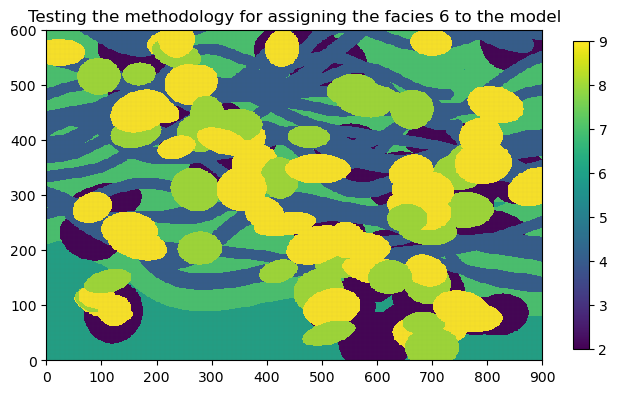

In [24]:
# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Next we create an instance of the PlotMapView class
mapview = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=11)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = mapview.plot_grid(alpha=0.01)
quadmesh = mapview.plot_array(facies)
t = ax.set_title("Testing the methodology for assigning the facies 6 to the model")
cb = plt.colorbar(quadmesh, shrink=0.5)

In [25]:
min_height = z_0
facies[Z > min_height] = 10
heights = np.arange(min_height, 7.1, 0.05)
x_c = -np.random.uniform(200, 300)
y_c = np.random.uniform(200, 600)
x = X[0, :, :].ravel()
y = Y[0, :, :].ravel()
P_0 = np.column_stack([x, y])

heights

array([6.5 , 6.55, 6.6 , 6.65, 6.7 , 6.75, 6.8 , 6.85, 6.9 , 6.95, 7.  ,
       7.05])

In [26]:
for height in heights:
    # adding initial channel
    size_indexes = 0
    while size_indexes < 200:
        gravel_channel = ferguson_curve(
            h=0.3,
            k=np.pi / 200,
            eps_factor=(np.pi) ** 2,
            flow_angle=0.0,
            s_max=1500 - x_c,
            xstart=x_c,
            ystart=y_c,
        )
        min_distance_arr, _ = min_distance(gravel_channel[0], gravel_channel[1], P_0)
        indexes = np.where(min_distance_arr < 200)
        indexes = indexes[0]
        xs = x[indexes]
        ys = y[indexes]
        size_indexes = xs.shape[0]
    print("adding peat lenses")
    p_tufa = 0
    thick = 0.2
    while p_tufa < 0.90:
        index_ = np.random.choice(np.arange(0, xs.shape[0]))
        x_t = xs[index_]
        y_t = ys[index_]
        z_t = height + thick
        a = np.random.uniform(60, 90)
        b = np.random.uniform(40, 50)
        c = np.random.uniform(thick, thick + 0.2)
        azim = np.random.uniform(70, 110)
        facies_trough, dip_dir_trough, dip_trough = trough(
            X,
            Y,
            Z,
            center_coords=np.array([x_t, y_t, z_t]),
            dims=np.array([a, b, c]),
            azim=azim,
            facies=np.array([11]),
        )
        facies[facies_trough == 11] = 11
        # k[facies_trough != -1] = np.random.lognormal(mu_tufa, sigma=sigma_tufa)
        logic_tufa = (Z >= height) & (Z <= height + thick)
        # calculating distance to the channel:
        xp = X[logic_tufa].ravel()
        yp = Y[logic_tufa].ravel()
        P = np.column_stack([xp, yp])
        min_distance_arr, _ = min_distance(gravel_channel[0], gravel_channel[1], P)
        nindexes = np.where(min_distance_arr < 200)
        nindexes = nindexes[0]
        p_tufa = np.sum(facies[logic_tufa].ravel()[nindexes] == 11) / np.sum(
            logic_tufa[logic_tufa].ravel()[nindexes]
        )
    ## Add channel facies:
    facies_, dip_, dipdir_ = channel(
        X,
        Y,
        Z,
        z_top=height + thick,
        curve=np.c_[gravel_channel[0], gravel_channel[1]],
        parabola_pars=np.array([25, thick + 0.2]),
        facies=np.array([12]),
    )
    facies[facies_ == 12] = 12
    print(f"Finished the layer {height}")

adding peat lenses
Finished the layer 6.5
adding peat lenses
Finished the layer 6.55
adding peat lenses
Finished the layer 6.6
adding peat lenses
Finished the layer 6.6499999999999995
adding peat lenses
Finished the layer 6.699999999999999
adding peat lenses
Finished the layer 6.749999999999999
adding peat lenses
Finished the layer 6.799999999999999
adding peat lenses
Finished the layer 6.849999999999999
adding peat lenses
Finished the layer 6.899999999999999
adding peat lenses
Finished the layer 6.949999999999998
adding peat lenses
Finished the layer 6.999999999999998
adding peat lenses
No points inside the ellipsoid
Finished the layer 7.049999999999998


In [54]:
y_c

198.75

In [27]:
np.unique(facies)

array([ 2,  4,  6,  7,  8,  9, 10, 11, 12])

In [80]:
np.sum(facies == 10) / np.size(facies)

0.0034314285714285714

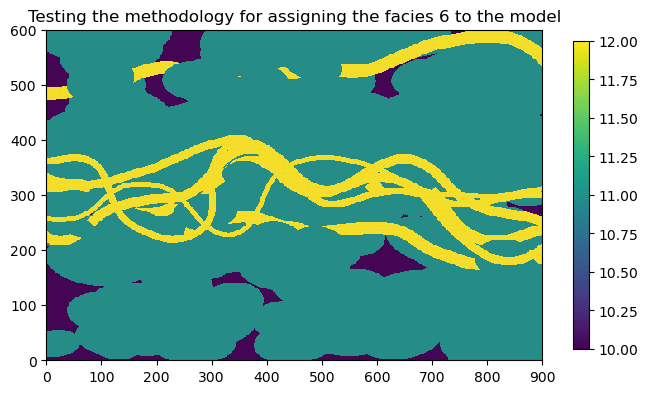

In [33]:
# First step is to set up the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Next we create an instance of the PlotMapView class
mapview = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = mapview.plot_grid(alpha=0.01)
quadmesh = mapview.plot_array(facies)
t = ax.set_title("Testing the methodology for assigning the facies 6 to the model")
cb = plt.colorbar(quadmesh, shrink=0.5)


We export the model as a VTK file for visualization using the flopy interface (For that I need to define a TIME!)

In [ ]:
# Simulation time:
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)]
)
# export numpy model:
centroid = np.stack([X, Y, Z])
np.save(
    "C:\\Users\\vcant\OneDrive\\Kassel\\ammer_field\\hyvr_models\\facies_v6.npy", facies
)
np.save(
    "C:\\Users\\vcant\OneDrive\\Kassel\\ammer_field\\hyvr_models\\centroid_v6.npy",
    centroid,
)

vtk = flopy.export.vtk.Vtk(model=gwf, modelgrid=grid)

vtk.add_array(facies, "facies")

vtk.write("ammer_v6")

: 